### Architecture of classification neural network

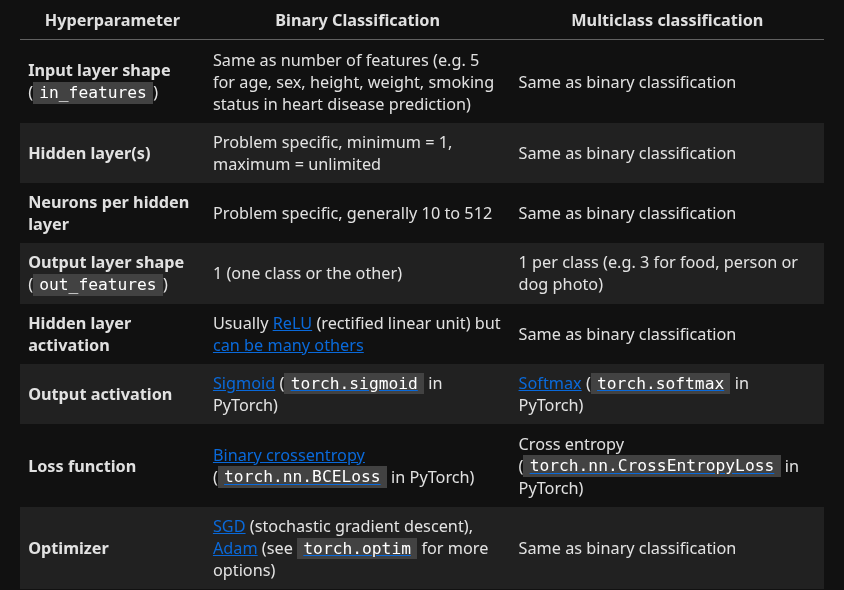

### Making classification data

Using `make_circles()` method from scikit-learn to generate two circles with different color dots

In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

In [2]:
print(f"First 5 X features \n {X[:5]}")
print(f"\n First 5 y labels : \n {y[:5]}")

First 5 X features 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

 First 5 y labels : 
 [1 1 1 1 0]


In [3]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2" : X[:, 1],
                        "label": y
                        })
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


##### Each pair of X features (X1 & X2) has a label (y) value of either 0 or 1.

This means that the we have to do a binary classification.

In [4]:
# check different labels

circles.label.value_counts()

,count
label,
1,500
0,500


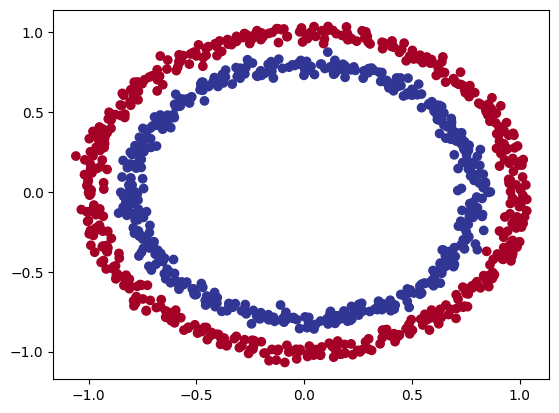

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### Important to check for the input and output shapes of the tensors


In [6]:
X.shape, y.shape

((1000, 2), (1000,))

here we got a match on first dimension of each i.e there's 1000 `X` and 1000 `y`.

But what's the second dim of `X` ?



In [7]:
# view the first example of features and labels

X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X : {X_sample} and the same for y : {y_sample}")
print(f"Shapes for one sample of X : {X_sample.shape} and the same for y : {y_sample.shape}")

Values for one sample of X : [0.75424625 0.23148074] and the same for y : 1
Shapes for one sample of X : (2,) and the same for y : ()


### from above we get the second dim for `X` means it has two features (vector) where as y has a single feature (scalar)


We have 2 inputs for one output

### Turn data into tensors and create train and test splits

In [8]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [10]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
## 1. Construct model class that subclasses nn.Module
class CircleModel(nn.Module):
  def __init__(self):

    super().__init__()

    ## 2. Create two nn.Linear layers capable of handling X & y i/p and o/p shapes

    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)  # takes in 2 features (X), produces 5 features
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)  # takes in 5 features, produces 1 feature (y)

  ##  3. Define a forward method containing the forward pass computation

  def forward(self, x):

    return self.layer_2(self.layer_1(x))

model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

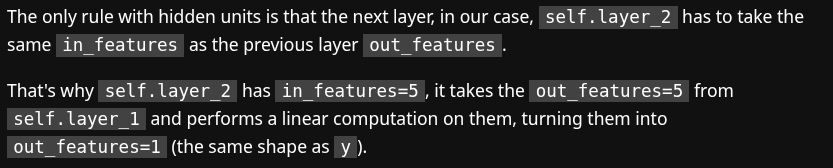

In [12]:
## We can also use nn.Sequential which performs a forward pass computation of the input data through the layers in the order they appear

model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)

).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Make predictions with the model

untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions : {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples : {len(y_test)}, Shape : {y_test.shape}")
print(f"\n First 10 predictions : \n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels : \n{y_test[:10]}")

Length of predictions : 200, Shape: torch.Size([200, 1])
Length of test samples : 200, Shape : torch.Size([200])

 First 10 predictions : 
tensor([[-0.2023],
        [-0.2384],
        [-0.1458],
        [-0.2181],
        [-0.2063],
        [-0.2279],
        [-0.2815],
        [-0.2792],
        [-0.1434],
        [-0.2414]], grad_fn=<SliceBackward0>)

First 10 test labels : 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Here from above we can see that there are same amount of predictions as there are test labels but the predictions don't look like they're in the same form or shape as the test labels

### Setup Loss function & Optimizer

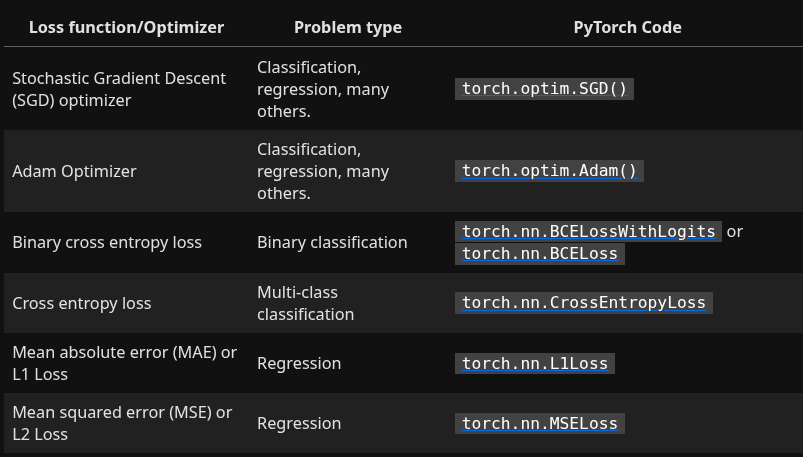

### PyTorch has two binary cross entropy implementations:

`torch.nn.BCELoss()` - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).

`torch.nn.BCEWithLogitsLoss()` - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in

In [14]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [15]:
## Calculate accuracy in classification metric

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [16]:
## View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2023],
        [-0.2384],
        [-0.1458],
        [-0.2181],
        [-0.2063]], grad_fn=<SliceBackward0>)

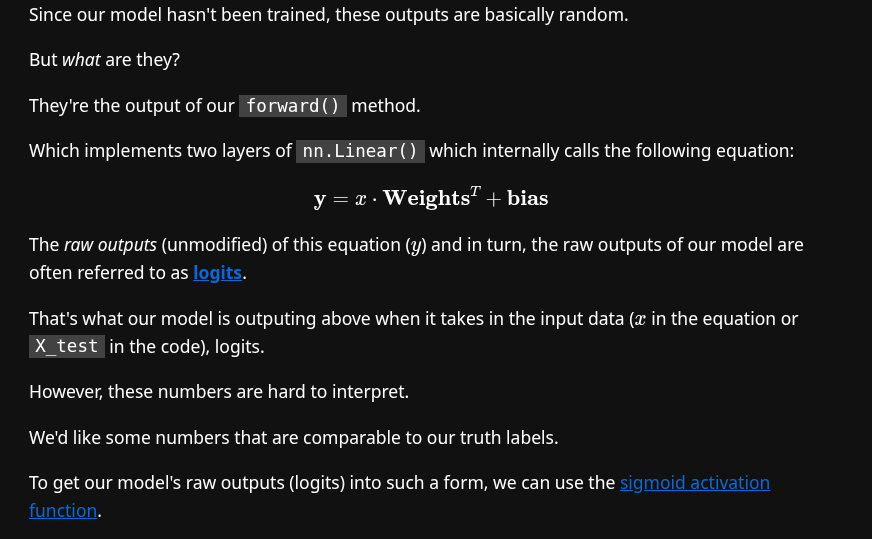

In [17]:
# Use sigmoid on model logits

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4496],
        [0.4407],
        [0.4636],
        [0.4457],
        [0.4486]], grad_fn=<SigmoidBackward0>)

Here we can see above we get somewhat consistency although it is random

if `y_pred_probs` >= 0.5 , `y = 1` (class = 1)

else class 0

In [18]:
# find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [19]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Building a training and testing loop

In [20]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluation loop
for i in range(epochs):

  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

###################################################
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
###################################################
  model_0.eval()
  with torch.inference_mode():

    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

    if i % 10 == 0:
      print(f"Epoch: {epochs} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 100 | Loss: 0.69896, Accuracy: 50.00% | Test loss: 0.69679, Test acc: 50.00%
Epoch: 100 | Loss: 0.69512, Accuracy: 50.00% | Test loss: 0.69390, Test acc: 50.00%
Epoch: 100 | Loss: 0.69393, Accuracy: 43.38% | Test loss: 0.69324, Test acc: 42.50%
Epoch: 100 | Loss: 0.69351, Accuracy: 47.38% | Test loss: 0.69317, Test acc: 44.50%
Epoch: 100 | Loss: 0.69332, Accuracy: 49.38% | Test loss: 0.69325, Test acc: 44.50%
Epoch: 100 | Loss: 0.69322, Accuracy: 50.12% | Test loss: 0.69337, Test acc: 45.50%
Epoch: 100 | Loss: 0.69316, Accuracy: 49.50% | Test loss: 0.69348, Test acc: 52.00%
Epoch: 100 | Loss: 0.69311, Accuracy: 48.88% | Test loss: 0.69359, Test acc: 51.50%
Epoch: 100 | Loss: 0.69308, Accuracy: 50.25% | Test loss: 0.69369, Test acc: 48.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.62% | Test loss: 0.69378, Test acc: 48.50%


### Make predictions and evaluate the model


In [21]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

  model.to(device)
  X, y = X.to(device), y.to(device)

  # setup prediction boundaries and grid
  x_min, x_max = X[:, 0].min() -0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() -0.1, X[:, 1].max() + 0.1

  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

  # Make features

  X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

  model.eval()
  with torch.inference_mode():
    y_logits = model(X_to_pred_on)

  if len(torch.unique(y)) > 2:
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)
  else:
    y_pred = torch.round(torch.sigmoid(y_logits))

  # Reshape preds and plot
  y_pred = y_pred.reshape(xx.shape).detach().numpy()
  plt.contourf(xx, yy, y_pred, cmap = plt.cm.RdYlBu, alpha = 0.7)
  plt.scatter(X[:, 0], X[:, 1], c = y, s = 40, cmap = plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())


def plot_predictions(train_data, train_labels, test_data, test_labels, predictions = None):

  plt.figure(figsize = (10, 7))

  plt.scatter(train_data, train_labels, c = "b", s = 4, label = "Training data")

  plt.scatter(test_data, test_labels, c = "g", s = 4, label = "Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c = "r", s =4, label = "Predictions")

  plt.legend(prop = {"size": 14})



### Plot deision boundaries for training and test sets

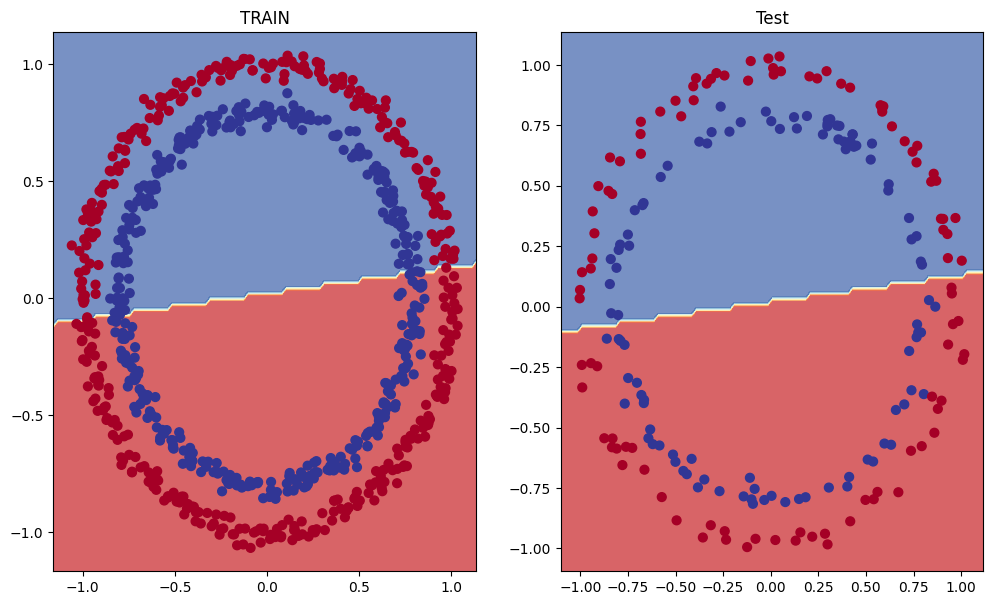

In [22]:
plt.figure(figsize = (12, 7))
plt.subplot(1,2,1)
plt.title("TRAIN")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## From above we can see that our model is **underfitting** as it is drawing a straight line though the middle of the circlular data points

### Improving a model
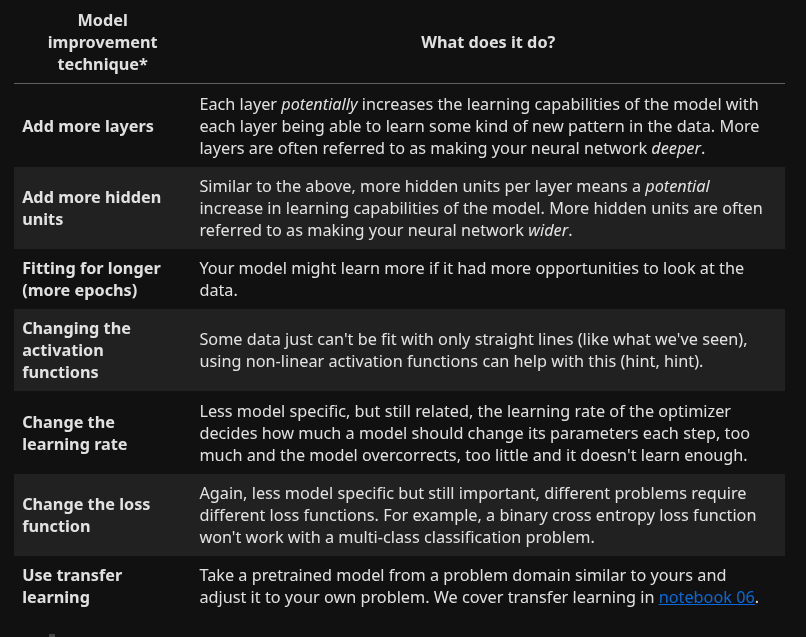

In [23]:
class CircleModel_V1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10) ## adding extra layer
    self.layer_3 = nn.Linear(in_features = 10, out_features =  1)

  def forward(self, x):

    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModel_V1().to(device)
model_1

CircleModel_V1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
# loss_fn = nn,BCELoss()  requires SIGMOID on input

loss_fn = nn.BCEWithLogitsLoss()       # doesn't require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.1)

In [25]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for i in range(epochs):

  y_logits = model_1(X_train).squeeze()
  y_ped = torch.round(torch.sigmoid(y_logits))  # logits => prediction prob => prediction labels

  loss =loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():

    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

  if i % 100 == 0:
    print(f"Epoch: {i} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.62% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.62% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 50.62% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 50.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 50.62% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 50.62% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 50.62% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 50.62% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 50.62% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 50.62% | Test loss: 0.69468, Test acc: 46.00%


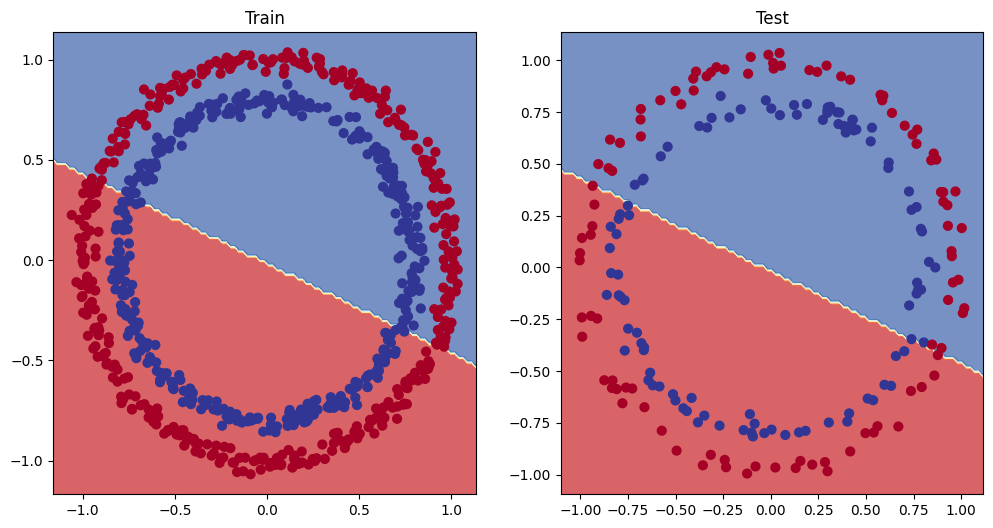

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Our Model is still drawing a straight line between the red and blue dots

### Preparing data to see if the model can model a stright line

In [27]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step ).unsqueeze(dim = 1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[: 5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [28]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[: train_split], y_regression[: train_split]

X_test_regression, y_test_regression= X_regression[train_split :], y_regression[train_split : ]

print(len(X_train_regression),
      len(y_train_regression),
      len(X_test_regression),
      len(y_test_regression))

80 80 20 20


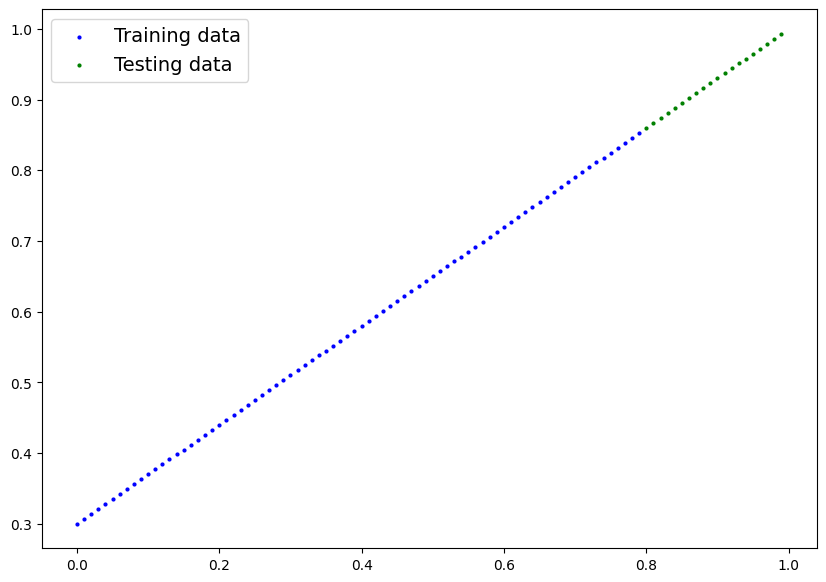

In [29]:
plot_predictions(train_data =X_train_regression, train_labels = y_train_regression, test_data = X_test_regression, test_labels = y_test_regression)

### Now adjusting `model 1` to fit a straight line

Recreating `model 1` but with a loss functions suited to our regression data

In [30]:
model_2= nn.Sequential(
    nn.Linear(in_features = 1, out_features = 10),
    nn.Linear(in_features = 10, out_features = 10),
    nn.Linear(in_features = 10, out_features = 1)
).to(device)

In [31]:
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.1)

In [33]:
torch.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for i in range(epochs):
  y_pred = model_2(X_train_regression)

  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()

  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if i % 100 == 0:
    print(f"Epoch: {i} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


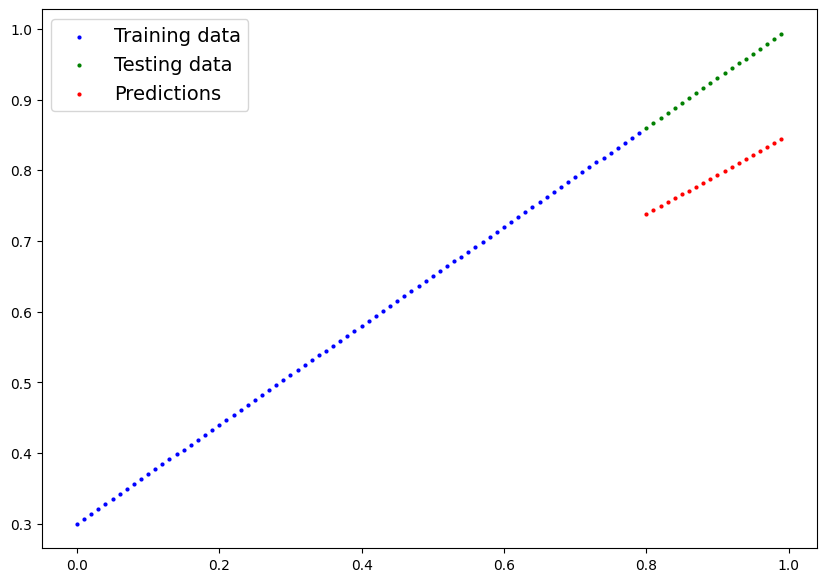

In [34]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels = y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = y_test_regression.cpu(),
                 predictions = y_preds.cpu());



## The Missing Piece : Non-Linearity

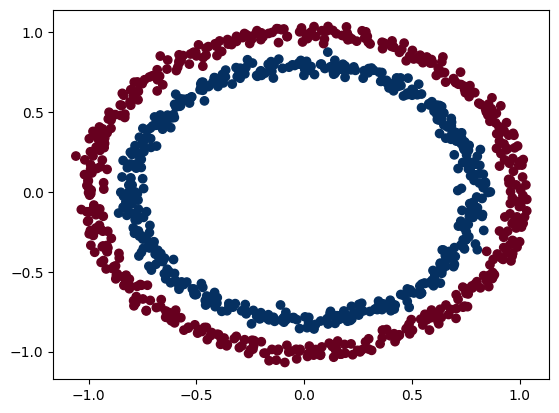

In [35]:
n_samples = 1000
X, y = make_circles(n_samples = 1000, noise = 0.03, random_state = 42,)

plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.RdBu)

In [36]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [37]:
X_train[: 5], y_train[: 5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [38]:
class CircleModel_V2(nn.Module):
  def __init__(self):

    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModel_V2().to(device)
print(model_3)

CircleModel_V2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [39]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr = 0.1)

### Training a model with non-linearity

In [40]:
## Initialize lists to track performance over epochs

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []


torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for i in range(epochs):

  y_logits = model_3(X_train).squeeze()
  y_pred =torch.round(torch.sigmoid(y_logits))

  loss= loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  ### Storing training metrics
  train_loss_history.append(loss.item())
  train_acc_history.append(acc)


  optimizer.zero_grad()
  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():

    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    ###   Storing test metrics
    test_loss_history.append(test_loss.item())
    test_acc_history.append(test_acc)


  if i % 100 == 0:
    print(f"Epoch: {i} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [51]:
# Assuming these lists were populated during the 1000 epochs:
# train_loss_history, train_acc_history, test_loss_history, test_acc_history

# Access the last item in the list (-1 index)
final_train_loss = train_loss_history[-1]
final_train_accuracy = train_acc_history[-1]
final_test_loss = test_loss_history[-1]
final_test_accuracy = test_acc_history[-1]

print(f"Final Training Performance")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.2f}% ")


Final Training Performance
Final Training Loss: 0.5689
Final Training Accuracy: 87.62%
Final Test Loss: 0.5744
Final Test Accuracy: 86.50% 


In [42]:
model_3.eval()

with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[: 10], y[: 10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

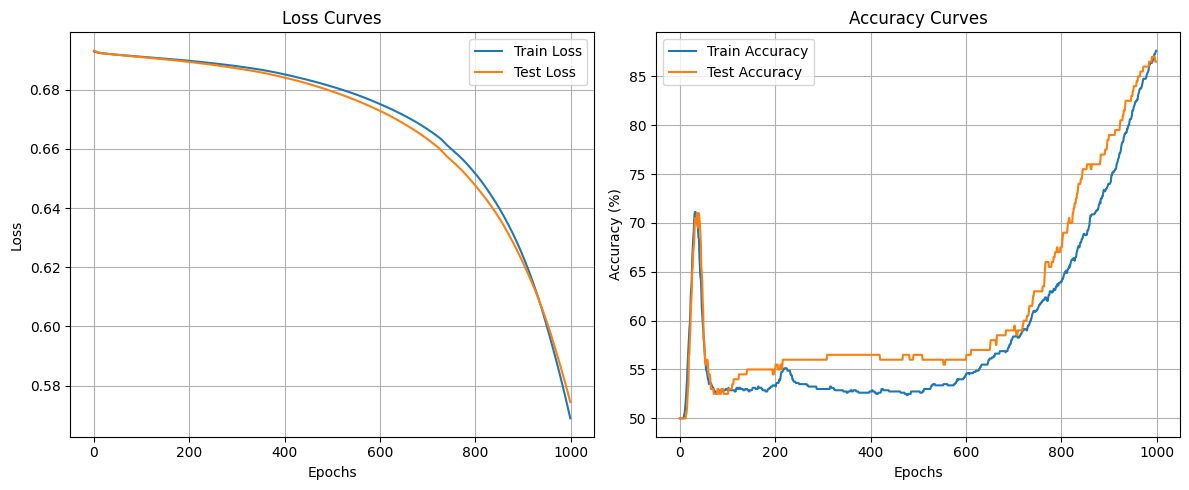

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Subplot 1: Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(test_acc_history, label="Test Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 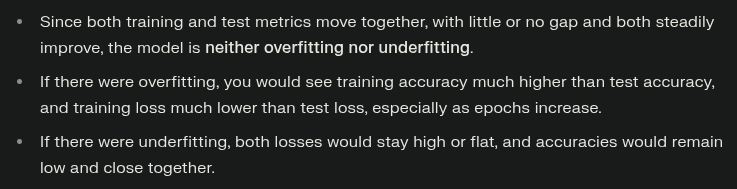

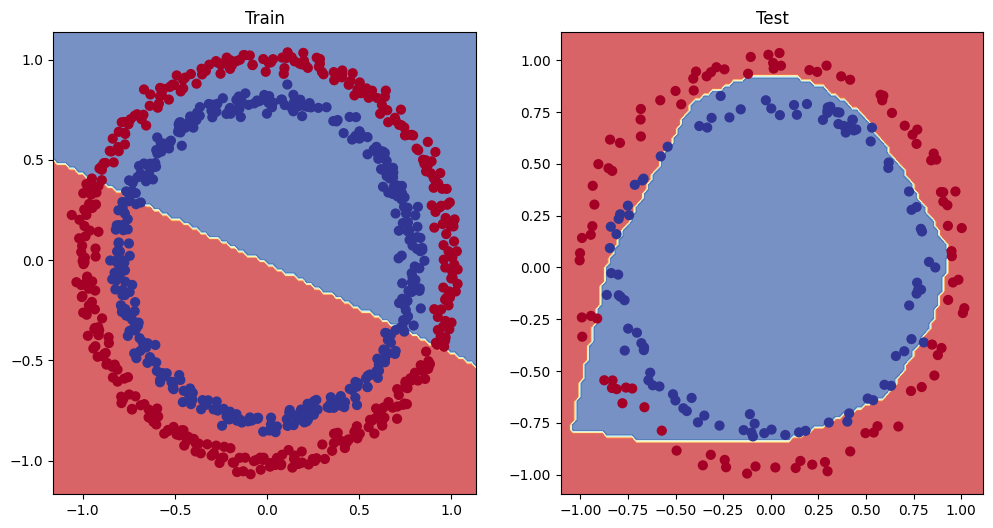

In [44]:
## plot decision boundaries for training and test set

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity